In [34]:
# import packages

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [18]:
#get the stock information (e.g. Apple)
df = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2020-04-30')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970
...,...,...,...,...,...,...
2020-04-24,283.010010,277.000000,277.200012,282.970001,31627200.0,282.970001
2020-04-27,284.540009,279.950012,281.799988,283.170013,29271900.0,283.170013
2020-04-28,285.829987,278.200012,285.079987,278.579987,28001200.0,278.579987


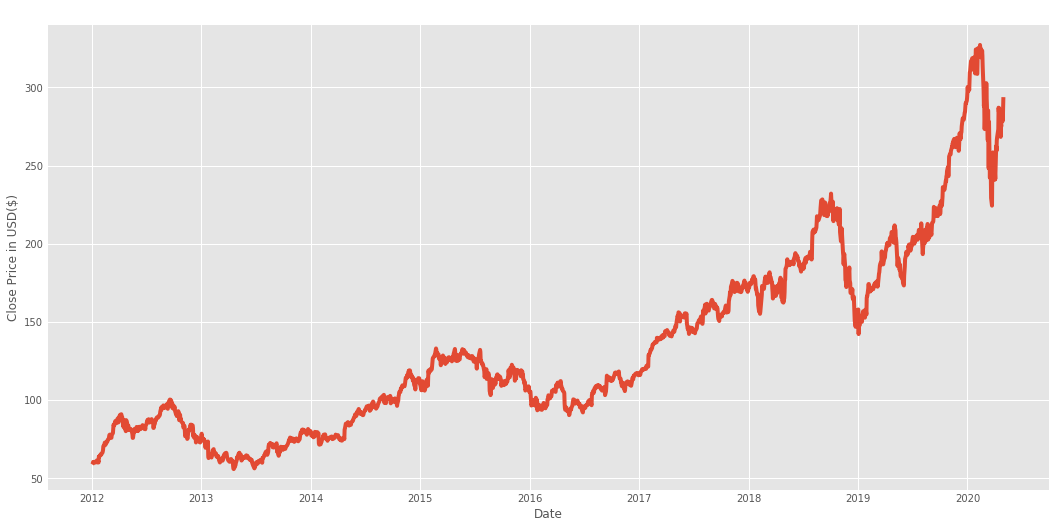

In [35]:
#Visualize the closing price
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price in USD($)')
plt.show()

In [20]:
#Create a new data frame with only the 'Close Column'
data = df.filter(['Close'])

#Convert the data frame to a numpy array
dataset = data.values

#Get the number of rows to train the model on (80%, can be adjusted)
training_data_len = math.ceil(len(dataset) * 0.8)

In [21]:
#Scale the data into [0,1]
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [22]:
#Create the scaled training data set
train_data = scaled_data[:training_data_len,]

#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

#remark: we predict a new value by using 60 days of history

In [23]:
#Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [24]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [25]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
#Train the model
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

Epoch 1/1
1616/1616 [==============================] - 43s 27ms/step - loss: 8.2076e-04


In [27]:
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60:,]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, ]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [28]:
#Convert the data to numpy array
x_test = np.array(x_test)

In [29]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
#Get the model#s predictive price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [31]:
#Get the RMSE (Root mean squared error)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

9.106901562198361

C:\Users\PatrickWong\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


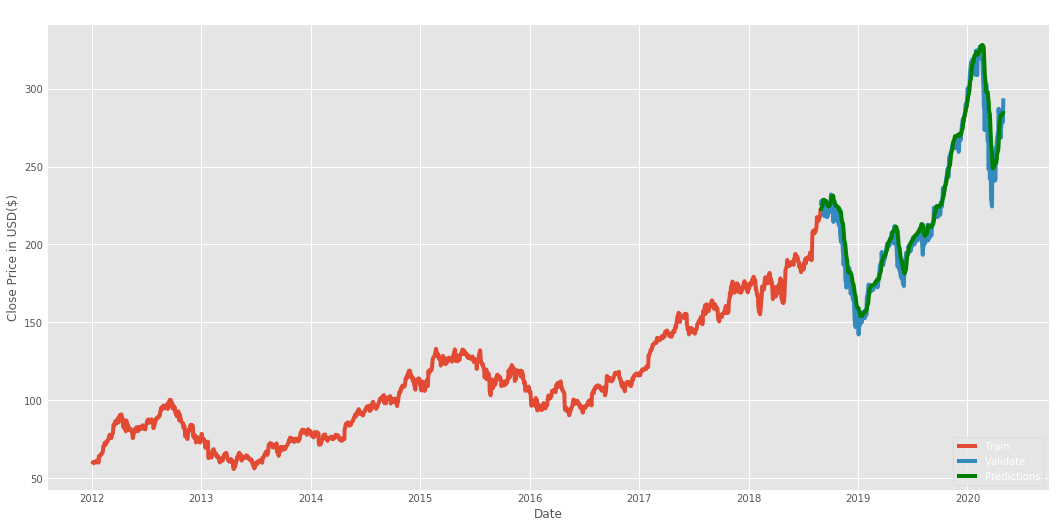

In [36]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price in USD($)')
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'], color = 'g')
plt.legend(['Train', 'Validate', 'Predictions'], loc = 'lower right')
plt.show()